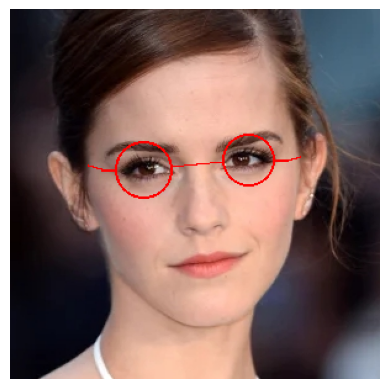

In [3]:
import os  # Модуль для роботи з файловою системою.
import cv2  # OpenCV для роботи із зображеннями (читання, обробка).
import numpy as np  # Бібліотека для чисельних обчислень (робота з масивами).
import pandas as pd  # Бібліотека для роботи з табличними даними.
import matplotlib.pyplot as plt  # Бібліотека для візуалізації зображень.
from PIL import Image, ImageDraw  # Pillow для роботи з зображеннями (додавання графічних елементів).

file_path = r'D:\piton\lab5\lab6.xlsx'  # Шлях до Excel-файлу з параметрами.
df = pd.read_excel(file_path)  # Зчитуємо таблицю з Excel у DataFrame.

variant_data = df[df['N'] == 1].iloc[0]  # Знаходимо рядок, де 'N' дорівнює 1, і беремо перший результат.
file_name = variant_data['file name']  # Отримуємо ім'я файлу з відповідного рядка.
image_size = tuple(map(int, variant_data['image size'].split('x')))  # Розмір кадру у вигляді кортежу (ширина, висота).
glasses_color = variant_data['glasses color']  # Колір окулярів, вказаний у таблиці.
line_width = variant_data['line width']  # Товщина ліній для окулярів.

img_path = r'D:\piton\lab5\images' + f'\\{file_name}'  # Формуємо шлях до зображення.
img = cv2.imread(img_path)  # Зчитуємо зображення за вказаним шляхом.

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Перетворюємо зображення в градації сірого для аналізу.

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  # Завантажуємо каскад для виявлення облич.
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')  # Завантажуємо каскад для виявлення очей.

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)  # Виявляємо обличчя на зображенні.

def add_glasses(img, faces, eye_cascade, glasses_color, line_width):
    """
    Додає окуляри на обличчя, використовуючи каскади для розпізнавання облич і очей.
    """
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Перетворюємо зображення OpenCV у формат Pillow.
    draw = ImageDraw.Draw(pil_img)  # Готуємо об'єкт для малювання.

    for (x, y, w, h) in faces:  # Проходимо через кожне знайдене обличчя.
        roi_gray = gray[y:y+h, x:x+w]  # Вирізаємо область обличчя в градаціях сірого.
        roi_color = img[y:y+h, x:x+w]  # Вирізаємо область обличчя у кольорі.
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Малюємо рамку навколо обличчя.

        eyes = eye_cascade.detectMultiScale(roi_gray)  # Виявляємо очі у межах обличчя.
        eyes = sorted(eyes, key=lambda ex: ex[0])  # Сортуємо очі за координатою X.

        if len(eyes) >= 2:  # Переконуємося, що знайдено щонайменше два ока.
            eye_centers = []  # Список для центрів очей.
            for (ex, ey, ew, eh) in eyes[:2]:  # Проходимо по перших двох очах.
                center = (x + ex + ew // 2, y + ey + eh // 2)  # Визначаємо центр ока.
                radius = ew // 2  # Визначаємо радіус ока.
                eye_centers.append((center, radius))  # Зберігаємо координати центру та радіус.
                draw.ellipse((center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius),
                             outline=glasses_color, width=line_width)  # Малюємо кола навколо очей.

            if len(eye_centers) == 2:  # Якщо знайдено два центри очей, малюємо місток та дужки окулярів.
                (left_eye_center, left_radius), (right_eye_center, right_radius) = eye_centers
                dx = right_eye_center[0] - left_eye_center[0]  # Відстань між очима по горизонталі.
                dy = right_eye_center[1] - left_eye_center[1]  # Відстань між очима по вертикалі.
                angle = np.arctan2(dy, dx)  # Кут між очима.

                left_bridge_point = (int(left_eye_center[0] + left_radius * np.cos(angle)),
                                     int(left_eye_center[1] + left_radius * np.sin(angle)))  # Ліва точка мостика.
                right_bridge_point = (int(right_eye_center[0] - right_radius * np.cos(angle)),
                                      int(right_eye_center[1] - right_radius * np.sin(angle)))  # Права точка мостика.

                draw.line([left_bridge_point, right_bridge_point], fill=glasses_color, width=line_width)  # Малюємо місток окулярів.

                temple_length = int(left_radius * 0.5)  # Довжина дужки окулярів.
                left_temple_point = (int(left_eye_center[0] - left_radius), left_eye_center[1])  # Ліва дужка.
                right_temple_point = (int(right_eye_center[0] + right_radius), right_eye_center[1])  # Права дужка.

                left_end_point = (left_temple_point[0] - temple_length, left_temple_point[1])  # Кінець лівої дужки.
                right_end_point = (right_temple_point[0] + temple_length, right_temple_point[1])  # Кінець правої дужки.

                draw.line([left_end_point, left_temple_point], fill=glasses_color, width=line_width)  # Ліва дужка.
                draw.line([right_temple_point, right_end_point], fill=glasses_color, width=line_width)  # Права дужка.

                angle_diagonal = np.radians(15)  # Кут нахилу дужки.
                diag_length = int(temple_length)  # Довжина нахиленої дужки.

                left_diag_point = (int(left_end_point[0] - diag_length * np.cos(angle_diagonal)),
                                   int(left_end_point[1] - diag_length * np.sin(angle_diagonal)))  # Кінцева точка лівої нахиленої дужки.
                draw.line([left_end_point, left_diag_point], fill=glasses_color, width=line_width)  # Ліва нахилена дужка.

                right_diag_point = (int(right_end_point[0] + diag_length * np.cos(angle_diagonal)),
                                    int(right_end_point[1] - diag_length * np.sin(angle_diagonal)))  # Кінцева точка правої нахиленої дужки.
                draw.line([right_end_point, right_diag_point], fill=glasses_color, width=line_width)  # Права нахилена дужка.

    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)  # Перетворюємо зображення назад у формат OpenCV.

img_with_glasses = add_glasses(img, faces, eye_cascade, glasses_color, line_width)  # Додаємо окуляри на зображення.

if len(faces) > 0:  # Якщо знайдено обличчя, обрізаємо його згідно з розмірами.
    x, y, w, h = faces[0]  # Беремо перше знайдене обличчя.
    face_center = (x + w // 2, y + h // 2)  # Центр обличчя.
    
    crop_x1 = max(0, face_center[0] - image_size[0] // 2)  # Координата X початку кадру.
    crop_x2 = min(img.shape[1], face_center[0] + image_size[0] // 2)  # Координата X кінця кадру.
    crop_y1 = max(0, face_center[1] - image_size[1] // 2)  # Координата Y початку кадру.
    crop_y2 = min(img.shape[0], face_center[1] + image_size[1] // 2)  # Координата Y кінця кадру.

    crop_width = crop_x2 - crop_x1  # Ширина кадру.
    crop_height = crop_y2 - crop_y1  # Висота кадру.
    
    if crop_width < image_size[0]:  # Якщо кадр занадто вузький, розширюємо.
        if crop_x1 == 0: 
            crop_x2 = min(crop_x2 + (image_size[0] - crop_width), img.shape[1])
        elif crop_x2 == img.shape[1]: 
            crop_x1 = max(crop_x1 - (image_size[0] - crop_width), 0)

    if crop_height < image_size[1]:  # Якщо кадр занадто низький, розширюємо.
        if crop_y1 == 0: 
            crop_y2 = min(crop_y2 + (image_size[1] - crop_height), img.shape[0])
        elif crop_y2 == img.shape[0]: 
            crop_y1 = max(crop_y1 - (image_size[1] - crop_height), 0)

    cropped_img = img_with_glasses[crop_y1:crop_y2, crop_x1:crop_x2]  # Вирізаємо кадр.
else:
    cropped_img = img_with_glasses  # Якщо обличчя не знайдено, використовуємо зображення з окулярами.

base_name, ext = os.path.splitext(file_name)  # Отримуємо ім'я та розширення файлу.
output_path = rf'D:\piton\lab5\images\{base_name}_with_glasses{ext}'  # Шлях для збереження результату.

cv2.imwrite(output_path, cropped_img)  # Зберігаємо результат у файл.

plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))  # Виводимо зображення.
plt.axis('off')  # Вимикаємо осі.
plt.show()  # Показуємо результат.
